# 2kb Bulk

Analysis of bulk data at 2kb level.

In [57]:
library(DESeq2)
library(ggplot2)
library(ggrepel)
library(reshape2)

In [60]:
cts <- read.csv("./data/bulk/counts.2kb.txt",sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chr = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)

,D0,D2,D4,D6,D8,D10,D12,D14
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1 10001 12000,58,0,0,56,0,0,0,0
chr1 180001 182000,258,63,194,236,129,73,70,135


In [61]:
# remove chrM
cts = cts[!grepl("chrM", rownames(cts)), ]
dim(cts)

[1] 705536      8

In [62]:
# this dataset was created by summing up the counts in the processed single cell dataset
# each day was processed separately and bins with low counts across all samples were removed
# upon merging that data back those missing rows were assigned zero counts, which can be problematic
cts = cts[rowSums(cts==0)==0,]
dim(cts)

[1] 124702      8

In [63]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [64]:
log_norm_cts = log10(1+norm_cts)

In [65]:
pca = prcomp(t(log_norm_cts),center=TRUE,scale=FALSE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained)

[1] 57.69 22.26  7.94  5.74  3.44  1.82  1.11  0.00


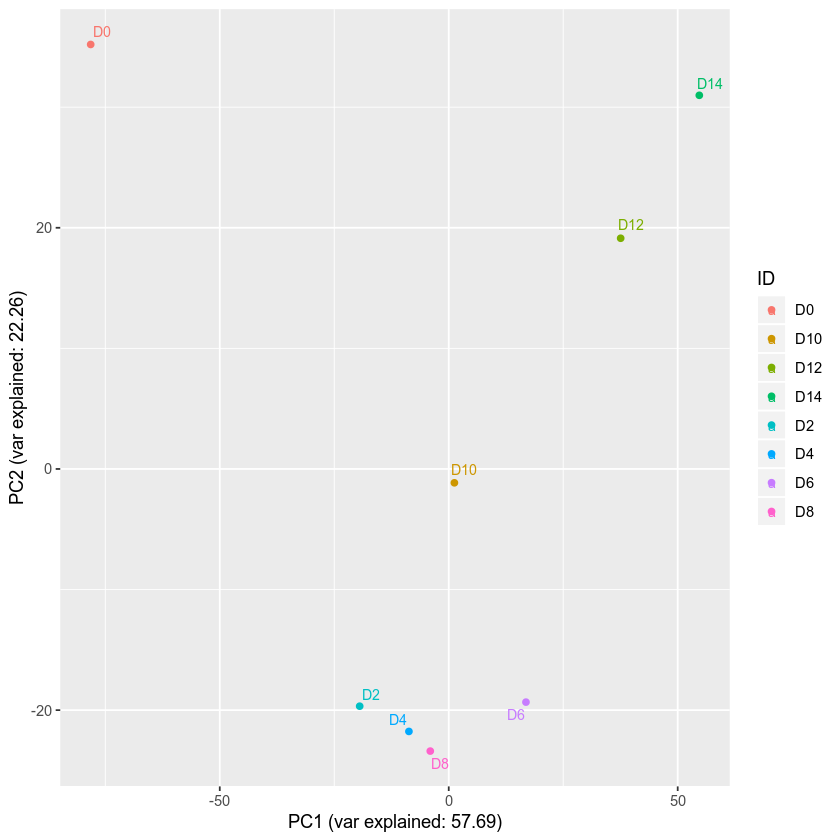

In [66]:
ggplot(data=pcs,aes(x=PC1,y=PC2,color=ID,label=ID))+
geom_point()+
geom_text_repel(size=3)+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

## Clustering

In [67]:
library(ClusterR)
library(viridis)
library(scales)

In [93]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(log_norm_cts, 
                        batch_size = 1000,
                        clusters=25,
                        num_init = 10, 
                        verbose = FALSE)

In [94]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(log_norm_cts, km_mb$centroids)
# distance    = dist(km_mb$centroids)
distance    = dist(t(scale(t(km_mb$centroids))))
cluster     = hclust(distance, method="ward")
dendrogram  = as.dendrogram(cluster)
rowInd = rev(order.dendrogram(dendrogram))
pr_mb = order(rowInd)[pr_mb]

The "ward" method has been renamed to "ward.D"; note new "ward.D2"


In [95]:
table(pr_mb)

pr_mb
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1841 4164 8739 2784 6609 2869 6135 7493 7578 4496 4312 2763 6584 7493 6815 3767 
  17   18   19   20   21   22   23   24   25 
2451 4452 1430 4143 7353 4546 5953 3561 6371 

In [96]:
log_norm_cts_clustered = log_norm_cts[order(pr_mb),]
head(log_norm_cts_clustered, 2)

,D0,D2,D4,D6,D8,D10,D12,D14
chr1 1410001 1412000,1.490185,2.466049,2.487540,2.712083,2.646185,2.545042,2.682184,2.832052
chr1 1468001 1470000,1.692422,2.345106,2.438375,2.699762,2.573258,2.563957,2.630202,2.737874


## Plotting

Saving 6.67 x 6.67 in image


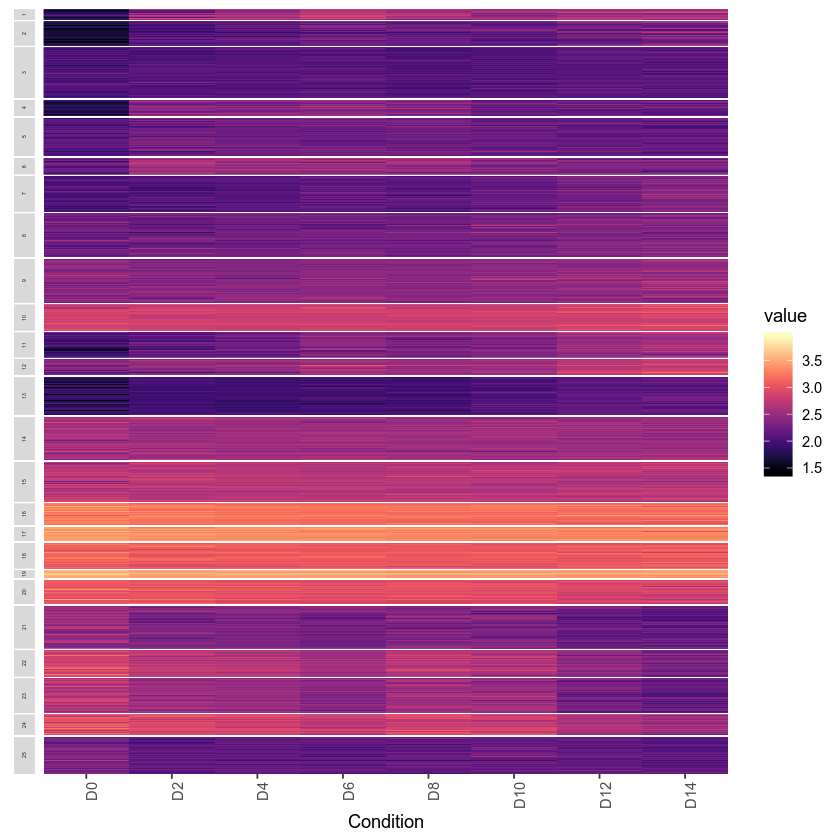

In [98]:
# Max color has been clipped!

idxs = seq(1, nrow(log_norm_cts_clustered), 1)
ggplot(data = melt(log_norm_cts_clustered[idxs,]), mapping = aes(x = Var2,
                                                         y = Var1,
                                                         fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(3.9, 8), oob=squish, option = "A") +
scale_fill_viridis(option="A") + 
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
      panel.spacing.y = unit(0.03, "cm"),
      strip.text.y = element_text(size = 3))
#       strip.background = element_rect(size = 0.1))

ggsave(sprintf("figs/%s_heatmap_2kb_intersect_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
       dpi=1000)

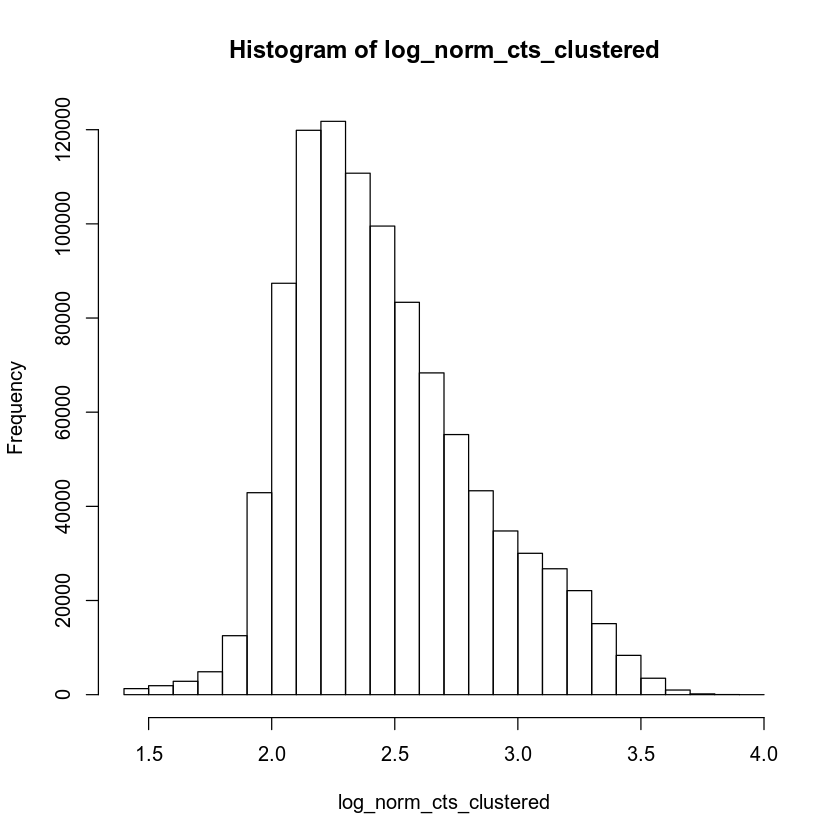

In [79]:
# See distribution of scores
hist(log_norm_cts_clustered)

## Writing BED files for some clusters

In [101]:
CLUSTER_IDX = 1
NORM = 'heatmap_2kb_intersect'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200119_heatmap_2kb_intersect_n25/idx1.bed"

In [103]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(rownames(log_norm_cts_clustered)[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [104]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(rownames(log_norm_cts_clustered), fileConn)
close(fileConn)

[1] "beds/20200119_heatmap_2kb_intersect_n25/all_peaks.bed"


Commands for motif analysis:

```for i in {1..5} ; do if [ ! -d homer/20200119_heatmap_2kb_intersect_n25/idx$i ] ; then findMotifsGenome.pl beds/20200119_heatmap_2kb_intersect_n25/idx$i.bed ~/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta homer/20200119_heatmap_2kb_intersect_n25/idx$i -nomotif -size given -bg beds/20200119_heatmap_2kb_intersect_n25/all_peaks.bed -p 8 ; fi ; done```